In [31]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(font_scale=1.2)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pylab 
import scipy.stats as stats

## 1. Data Loading

In [32]:
!ls

Datasets
ML_Project_KM.ipynb
README.MD
Wenchang_Qian_Kaggle_Ames_Iowa_Housing_Price_Prediction.ipynb
james_proj3_ini.ipynb
jamesczq_baseline_regressions.ipynb


In [33]:
!ls Datasets

data_description.txt  test.csv
sample_submission.csv train.csv


In [34]:
train = pd.read_csv('Datasets/train.csv')
test = pd.read_csv('Datasets/test.csv')

In [35]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [36]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [37]:
#train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [38]:
# Concat. train[no ID column, ... (all columns) ..., no SalePrice column]
#     with test[no ID column, ... (all columns) ..., no SalePrice column]
# (Test data has no SalePrice column anyway)

train_test = pd.concat([train.loc[:,'MSSubClass':'SaleCondition'],
                         test.loc[:,'MSSubClass':'SaleCondition']]);

train_test.shape

(2919, 79)

## 2. Data Pre-Processing
* 2.1 Some Preliminary Examination and Symmetrization
* 2.2 Fill in NAs
* 2.3 Encode Categorical Features
* 2.4 Set up training and test data matrices

### 2.1 (a) Preliminary Examination

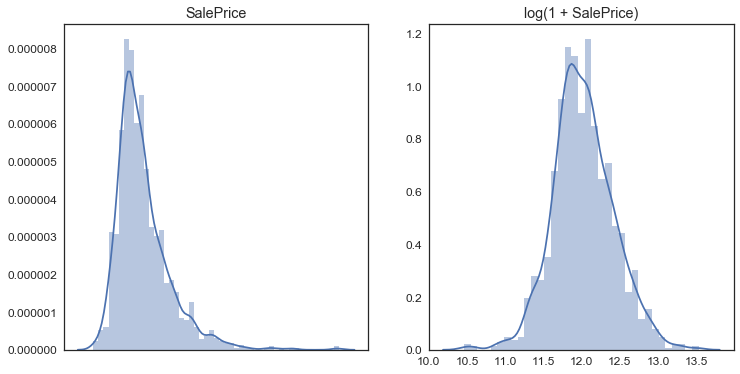

In [39]:
sns.set_style("white")
#sns.set(font_scale=1.2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,6));
sns.distplot(           train.SalePrice,  ax=ax1);
sns.distplot(np.log(1 + train.SalePrice), ax=ax2);

# Turn off ax1(left panel) x-ticks; not intelligible anyway
ax1.xaxis.set_major_locator(plt.NullLocator());
ax1.set_xlabel('');
ax1.set_title('SalePrice');

ax2.set_xlabel('');
ax2.set_title('log(1 + SalePrice)');

In [40]:
# As observed, symmetrize SalePrice via log(1 + ***)
train.SalePrice = np.log(1 + train.SalePrice)

### 2.1 (b) Symmetrization

In [41]:
# Likewise, log transform those skewed numeric features
from scipy.stats import skew

# Set the threshold for being over-skewed
# (can tune later)
skew0 = 0.6;

There are 27 numerical features (out of 36) deemed to be skewed.


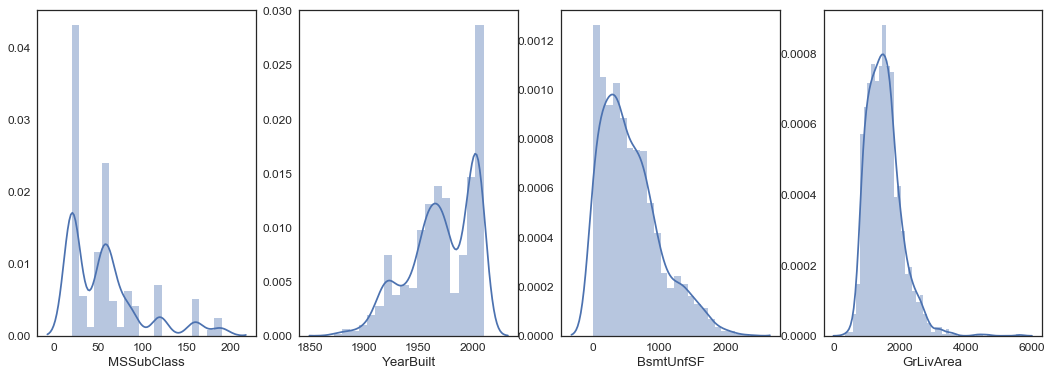

In [42]:
numeric_features = train_test.dtypes[train_test.dtypes != "object"].index

skewed_features = train[numeric_features].apply(lambda x: skew(x.dropna())) 
skewed_features = skewed_features[abs( skewed_features ) > skew0]
skewed_features = skewed_features.index

# Visual examination
print('There are {} numerical features (out of {}) deemed to be skewed.'.\
      format(train[skewed_features].shape[1],numeric_features.shape[0]))

# look at four of them
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize = (18,6));
sns.distplot(train[numeric_features[0]], ax=ax1);
sns.distplot(train[numeric_features[5]], ax=ax2);
sns.distplot(train[numeric_features[10]], ax=ax3);
sns.distplot(train[numeric_features[15]], ax=ax4);

In [43]:
train_test[skewed_features] = np.log(1 + train_test[skewed_features])

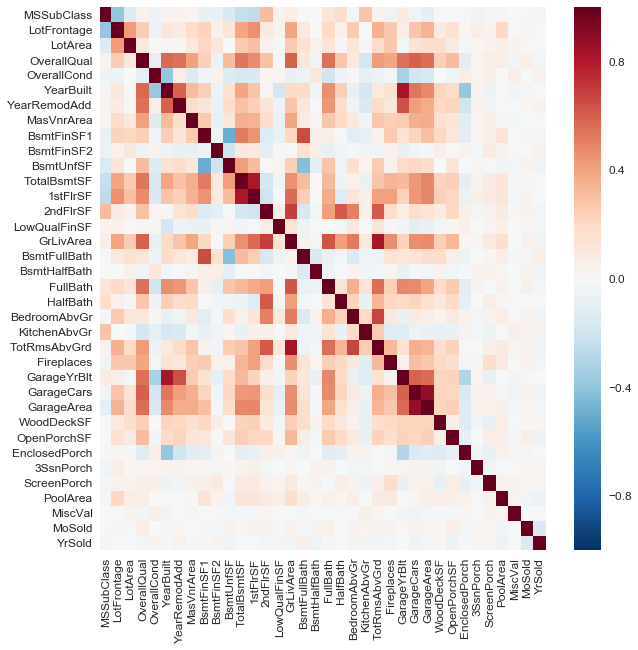

In [44]:
fig, ax = plt.subplots(ncols=1, figsize = (10,10));
sns.heatmap(train[numeric_features].corr())
sns.set(font_scale = 1)

### 2.2 Encode Categorical Features
#### Using plain and simple one-hot encoding

In [45]:
train_test = pd.get_dummies(train_test)
train_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,1.791759,7.602900,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,2.197225,7.589336,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,1.791759,7.601902,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,1.791759,7.557995,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,1.791759,7.601402,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


### 2.3 Fill in NAs

#### Interpolating NAs with the median of each field

In [46]:
train_test = train_test.fillna(train_test.median())

### 2.4 Set up training and test data matrices

In [47]:
X_train = train_test[:train.shape[0]]
X_test  = train_test[train.shape[0]:]
y_train = train.SalePrice

## 3. Modeling

### Linear Regression with $L_{1}$ Lasso or $L_{2}$ Ridge Regularizations

In [48]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt( -cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

### 3.1 Try with Ridge 
#### where $\alpha$ is as in $L(\ \vec{\beta} \ ) = MSE + \alpha \cdot \frac{1}{2} ||\ \vec{\beta}\ ||_{L_{2}}$

In [49]:
from sklearn.linear_model import Ridge

model_Ridge = Ridge()

In [50]:
# supply a log-ranged alphas from 10^(-2) to 10^(2)
# total: 60 alphas to do CV
alpha_array = np.logspace(-1,2,64)

cv_Ridge = [rmse_cv(Ridge(alpha = Alpha)).mean() for Alpha in alpha_array]

**************************************************
Ridge CV:
Minumum RMSE 0.1280 
achieved at alpha = 8.9615
**************************************************


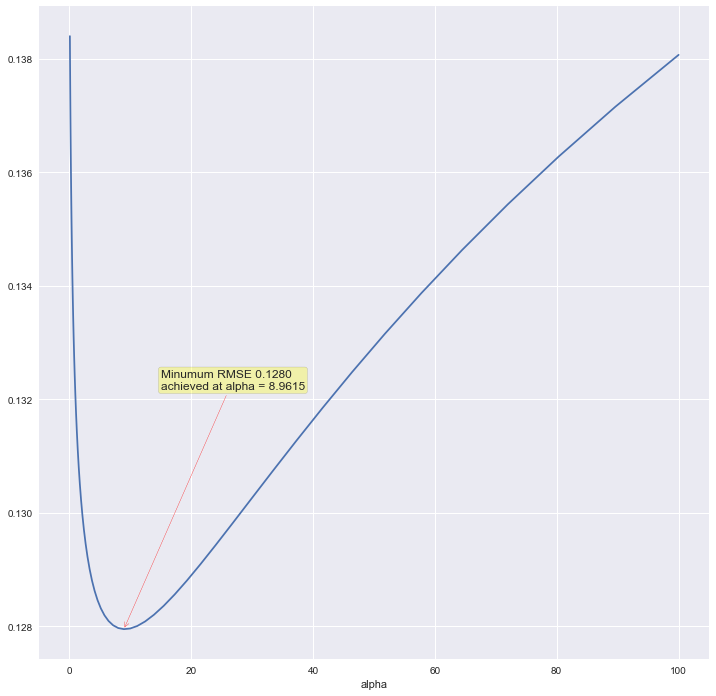

In [51]:
cv_Ridge = pd.Series(cv_Ridge, index = alpha_array)

fig, ax = plt.subplots(figsize=(12,12));
ax.plot(alpha_array,cv_Ridge);
ax.set_xlabel('alpha')
#ax.set_ylabel('RMSE')
alpha0 = cv_Ridge[cv_Ridge == cv_Ridge.min()].index[0];
rmse0 = cv_Ridge.min();
s = 'Minumum RMSE {:.4f} \nachieved at alpha = {:.4f}'.format(rmse0,alpha0)
ax.annotate(s, xy=(alpha0, rmse0),
               xycoords='data',
               xytext=(alpha_array.mean(), cv_Ridge.mean()),
               #textcoords='offset points',
               bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
               arrowprops=dict(arrowstyle='->',color='red'))

print('*'*50)
print('Ridge CV:')
print(s)
print('*'*50)

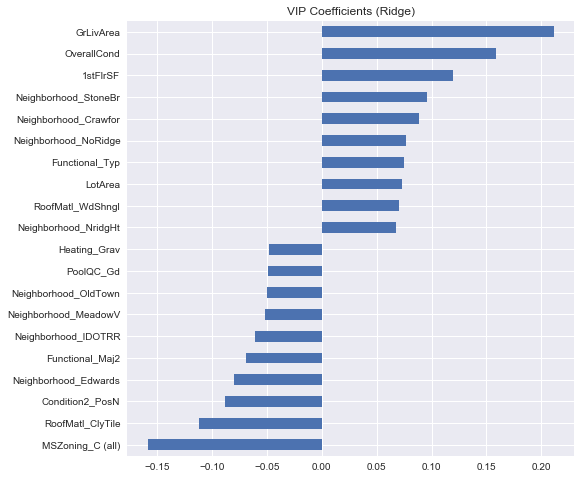

In [52]:
model_Ridge = Ridge(alpha0).fit(X_train, y_train);

coeffs_Ridge = pd.Series(model_Ridge.coef_, index = X_train.columns);
vip_coeffs_Ridge = pd.concat([coeffs_Ridge.sort_values().head(10),
                              coeffs_Ridge.sort_values().tail(10)])

fig, ax = plt.subplots(figsize=(8,8));
vip_coeffs_Ridge.plot(kind = "barh");
plt.title("VIP Coefficients (Ridge)");

**************************************************
Ridge Performace: R^2 = 0.9299
**************************************************


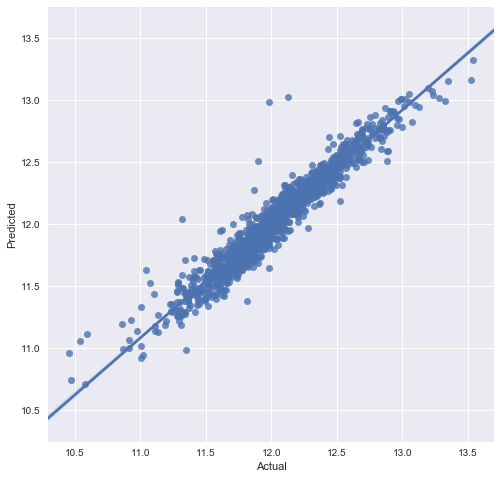

In [53]:
predictions_Ridge = pd.DataFrame({"Predicted":model_Ridge.predict(X_train), 
                                  "Actual":y_train});
predictions_Ridge["Residual"] = predictions_Ridge.Actual - predictions_Ridge.Predicted;


print('*'*50)
print('Ridge Performace: R^2 = {:.4f}'.format(model_Ridge.score(X_train, y_train)))
print('*'*50)


fig, ax = plt.subplots(figsize=(8,8));
sns.regplot(predictions_Ridge.Actual, predictions_Ridge.Predicted);
#ax.set_title('')

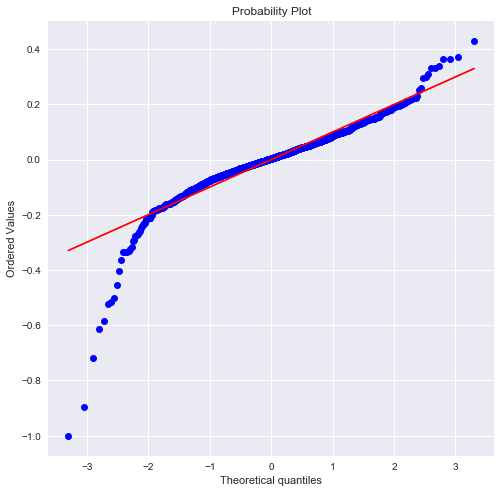

In [54]:
fig, ax = plt.subplots(figsize=(8,8));
stats.probplot(predictions_Ridge.Residual, dist="norm", plot=pylab);
pylab.show();

### 3.2 Try with Lasso 
#### where $\alpha$ is as in $L\left( \vec{\beta} \right) = MSE + \alpha \cdot ||\vec{\beta}||_{L_{1}}$

In [55]:
from sklearn.linear_model import Lasso

model_Lasso = Lasso()

In [56]:
# supply a log-ranged alphas from 10^(-2) to 10^(2)
# total: 60 alphas to do CV
alpha_array = np.linspace(10,0.0005,64)

cv_Lasso = [rmse_cv(Lasso(alpha = Alpha)).mean() for Alpha in alpha_array]

**************************************************
Lasso CV:
Minumum RMSE 0.1234 
achieved at alpha = 0.0005
**************************************************


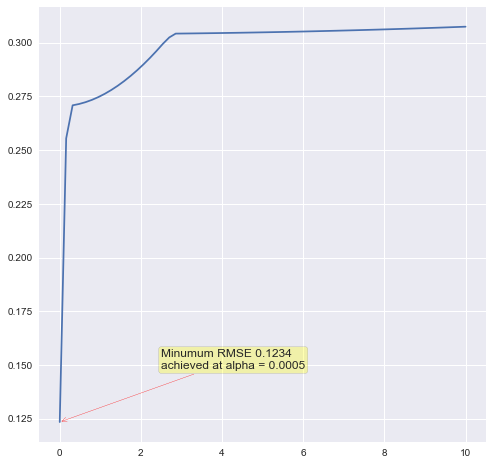

In [57]:
cv_Lasso = pd.Series(cv_Lasso, index = alpha_array)

fig, ax = plt.subplots(figsize=(8,8));
ax.plot(alpha_array,cv_Lasso);

alpha0 = cv_Lasso[cv_Lasso == cv_Lasso.min()].index[0];
rmse0 = cv_Lasso.min();
s = 'Minumum RMSE {:.4f} \nachieved at alpha = {}'.format(rmse0,alpha0)
ax.annotate(s, xy=(alpha0, rmse0),
               xycoords='data',
               xytext=(alpha_array.mean()/2, cv_Lasso.mean()/2),
               #textcoords='offset points',
               bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
               arrowprops=dict(arrowstyle='->',color='red'))

print('*'*50)
print('Lasso CV:')
print(s)
print('*'*50)

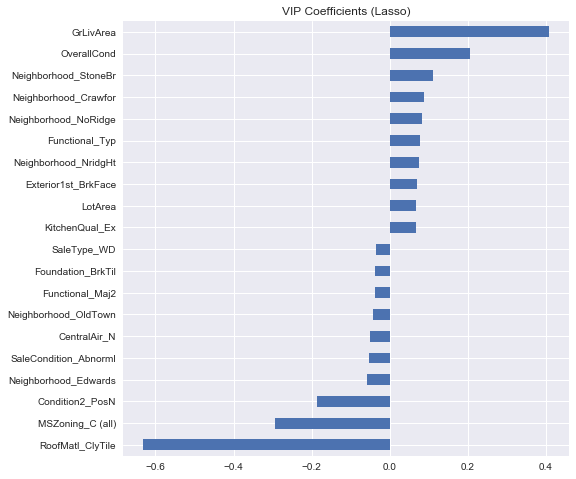

In [58]:
model_Lasso = Lasso(alpha0).fit(X_train, y_train);


coeffs_Lasso = pd.Series(model_Lasso.coef_, index = X_train.columns);
vip_coeffs_Lasso = pd.concat([coeffs_Lasso.sort_values().head(10),
                              coeffs_Lasso.sort_values().tail(10)])

fig, ax = plt.subplots(figsize=(8,8));
vip_coeffs_Lasso.plot(kind = "barh");
plt.title("VIP Coefficients (Lasso)");

**************************************************
Lasso Performace: R^2 = 0.9296
**************************************************


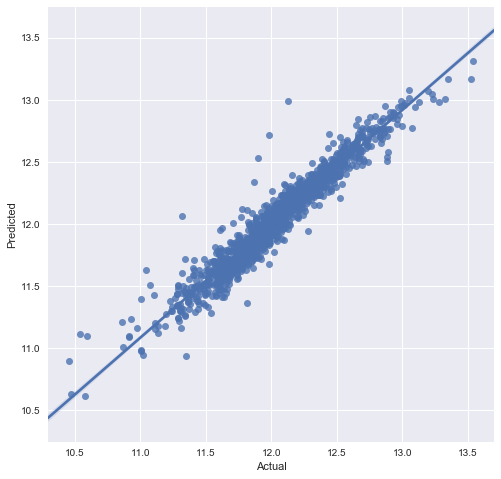

In [59]:
predictions_Lasso = pd.DataFrame({"Predicted":model_Lasso.predict(X_train), 
                                  "Actual":y_train});
predictions_Lasso["Residual"] = predictions_Lasso.Actual - predictions_Lasso.Predicted;


print('*'*50)
print('Lasso Performace: R^2 = {:.4f}'.format(model_Lasso.score(X_train, y_train)))
print('*'*50)


fig, ax = plt.subplots(figsize=(8,8));
sns.regplot(predictions_Lasso.Actual, predictions_Lasso.Predicted);
#ax.set_title('')

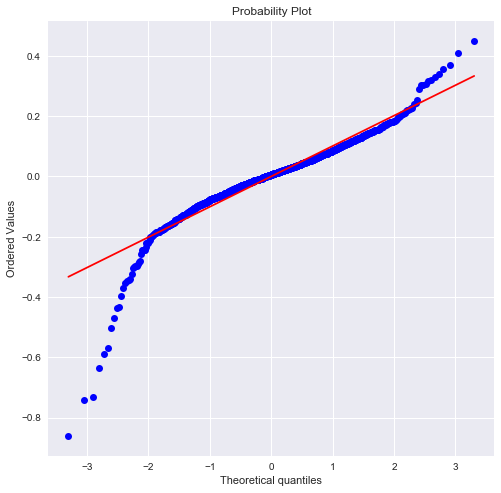

In [60]:
fig, ax = plt.subplots(figsize=(8,8));
stats.probplot(predictions_Lasso.Residual, dist="norm", plot=pylab);
pylab.show();